In [114]:
# 종속변수

# 1) 향후 10분 후 종가 기준 리턴: returns
# 2) bid price 및 ask price 기준 10분 동안 실질적 리턴: returns_next10m
# 3) 10분 동안 realized volatility: realized_vol_next10m


### 1. Initialization

In [129]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns


'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''
torch.manual_seed(0)

# GPU 사용 가능 환경인지 확인 -> mac의 경우 GPU가 아는 MPS를 사용
print(f"mps 사용 가능 여부: {torch.backends.mps.is_available()}")
print(f"mps 지원 환경 여부: {torch.backends.mps.is_built()}")

device = torch.device("mps")

# 파라미터 초기화
# seq_length = 7 # 시퀀스 데이터 길이
# data_dim = 6 # Feature 개수
# hidden_dim = 10 # 은닉층 차원
# output_dim = 1 # 출력 차원
# learning_rate = 0.01 # 학습률
# epochs = 500 # 에폭, 학습 횟수
# batch_size = 100 # 배치 사이즈


mps 사용 가능 여부: True
mps 지원 환경 여부: True


### 2. Data Preprocessing

In [2]:
# 학습용 데이터 셋 생성 함수
# Sequence data를 만들어서 numpy array로 반환
def build_dataset(data, seq_len):
    dataX = []
    dataY = []
    for i in range(len(data)-seq_len):
        x = data[i:i+seq_len, :]
        y = data[i+seq_len, [-1]]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

# 데이터 불러오기
file_path = '../../data/'
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_9.csv')
df = df.iloc[:10000]
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
print("before: ", df.shape)

# Data Preprocessing
# 필요한 Feature만 추출한 데이터
target_var = df[['returns', 'returns_next10m', 'realized_vol_next10m']] # 종속변수
df.drop(columns=['returns', 'returns_next10m', 'realized_vol_next10m'], inplace=True) # 독립변수
print("after: ", df.shape)
print(df.head())

# 무한대에 해당하는 값 제거
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 독립변수 카테고리화
target_var['returns_next10m'] = target_var['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1

# 독립변수 중 사용할 변수만 가져오기(+정규화)
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id'])) # 위 변수를 제외한 모든 변수
y = target_var['returns_next10m'].values # 종속변수


NameError: name 'pd' is not defined

In [3]:
# 시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length]) # a[2:6] -> 2,3,4,5
        y_seq.append(y[i+sequence_length])
    
    # view를 사용하여 2차원으로 바꿈(MSE Loss가 기본적으로 2차원 타깃 데이터를 받음)
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1) 

split = int(len(df)*0.7) # 70%를 학습 데이터로
sequence_length = 5 # 30s * 5 = 2m 30s를 시퀀스 길이로
x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())


NameError: name 'df' is not defined

In [118]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
batch_size = 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size)

In [119]:
# 하이퍼 파라미터 정의
input_size = x_seq.size(2) # feature 개수
num_layers = 2 # 은닉층의 개수
hidden_size = 8 # 은닉 상태를 저장하는 벡터의 크기

In [120]:
# 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 선형 층의 입력 크기 계산이 필요. 예시에서는 간단히 hidden_size를 사용.
        # sequence_length와의 관계를 정확히 계산하여 적용해야 함.
        self.fc = nn.Linear(hidden_size, 1)  # 출력 크기를 1로 설정
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # 마지막 시퀀스의 출력만 사용
        out = self.fc(out)
        out = torch.sigmoid(out)  # 시그모이드 활성화 함수 적용
        return out


In [121]:
# 모델 불러오기
model = LSTM(input_size=input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers=num_layers,
             device=device).to(device)

In [122]:
# 손실 함수 및 최적화 방법 정의
criterion = nn.BCELoss()  # 손실 함수를 BCELoss로 변경
num_epochs = 301
optimizer = optim.Adam(model.parameters(), lr=1e-3) # 0.001


In [123]:
# 모델 학습하기
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq) # 출력값 산출
        loss = criterion(out, target) # 손실함수 계산

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # 최적화
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.6932
[epoch: 100] loss: 0.6594
[epoch: 200] loss: 0.6478
[epoch: 300] loss: 0.6261


0(negative) target ratio: 0.6015625
1(positive) target ratio: 0.3984375
-----------------------------------
Accuracy: 0.59375
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


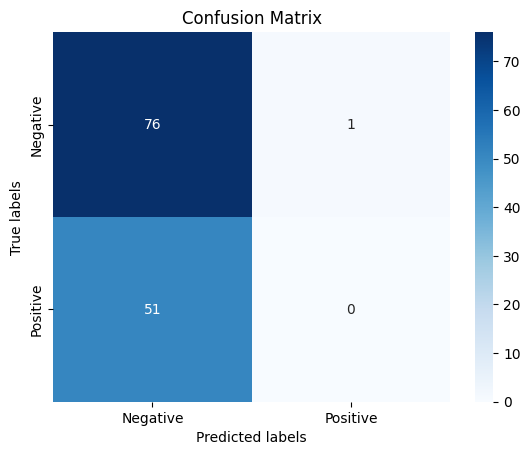

In [148]:
# 분류 성능 확인
# out = model(x)
predictions = torch.round(out).detach().cpu().numpy()  # 확률을 반올림하여 예측값 계산, CPU로 이동
target_np = target.detach().cpu().numpy()  # 실제 레이블을 numpy 배열로 변환, CPU로 이동

# Data imbalance check
print(f"0(negative) target ratio: {np.sum(target_np == 0) / len(target_np)}")
print(f"1(positive) target ratio: {np.sum(target_np == 1) / len(target_np)}")
print('-----------------------------------')

# metrics
accuracy = accuracy_score(target_np, predictions) # 정확도 계산
precision = precision_score(target_np, predictions) # 정밀도 계산
recall = recall_score(target_np, predictions) # 재현율 계산
f1 = f1_score(target_np, predictions) # F1 스코어 계산

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('-----------------------------------')

# confusion matrix
cm = confusion_matrix(target_np, predictions) # 혼동 행렬 계산
fig, ax = plt.subplots() # 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)  # 혼동 행렬을 히트맵으로 표시
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()


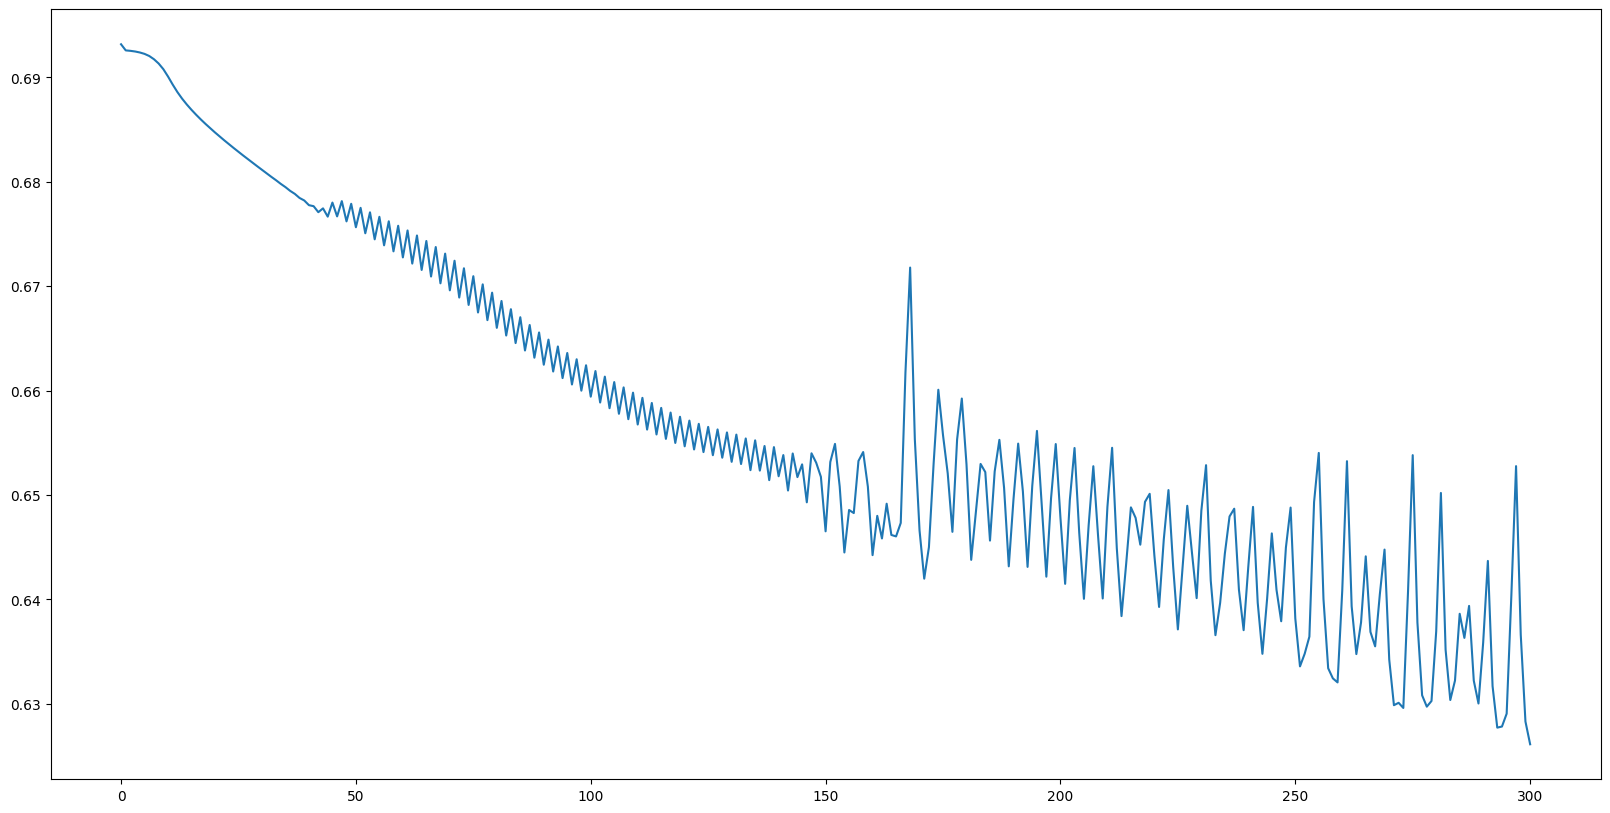

In [124]:
# 학습 손실 함수값 그리기
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()